In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
def n2action(s0,n):
    s = s0.copy()
    if n == 0:
        s[0] += 1
    elif n == 1:
        s[0] -=1
    elif n == 2:
        s[1] += 1
    elif n == 3:
        s[1] -=1
    np.clip(s,0,9,out=s)
    return s

def rand_action(s):
    a = np.random.randint(5)
    return n2action(s,a)

def policy2(q,s,e):
    policy = np.ones((5))*e/5
    best = q[s[0],s[1]] == np.max(q[s[0],s[1]])
    policy[best] += (1-e)/best.sum()
    return policy

def policy(q,s,e):
    policy = np.ones((5))*e/5
    best = np.argmax(q[s[0],s[1]])
    policy[best] += (1-e)
    return policy

def max_action(q,s,e=0.1):
    a = np.random.choice(np.arange(5),p=policy(q,s,e))
    return (n2action(s,a), a)

def updateQ(q, s0, a0, q1):
    q[s0[0],s0[1],a0] += 1*(0.9*q1-1-q[s0[0],s0[1],a0])
    return q

def plot_grid(s):
    g = np.zeros([10,10])
    g[s[0],s[1]] = 1
    plt.pcolormesh(g,cmap="binary",edgecolors="black")
    plt.show()

def plot_greedy(q,max_steps = 50):
    g = np.zeros([10,10])
    end = np.array([9,9])

    i = 0
    s = np.array([0,0])
    g[s[0],s[1]] += 1
    while np.any(s != end) and i < max_steps:
        s, _ = max_action(q,s,e=0)
        g[s[0],s[1]] += 1
        i += 1
    plt.pcolormesh(g,cmap="binary",edgecolors="black")
    plt.show()

def plot_maxq(q):
    sns.heatmap(np.amax(q,axis=-1),annot=True,cbar=False).invert_yaxis() 
    plt.show()
    
def plot_q(q):
    plt.figure(figsize=(20,3))
    plt.subplot(1,4,1)
    sns.heatmap(q[...,0],annot=True,cbar=False).invert_yaxis() 
    plt.title("Haut")
    plt.subplot(1,4,2)
    sns.heatmap(q[...,1],annot=True,cbar=False).invert_yaxis() 
    plt.title("Bas")
    plt.subplot(1,4,3)
    sns.heatmap(q[...,2],annot=True,cbar=False).invert_yaxis() 
    plt.title("Droite")
    plt.subplot(1,4,4)
    sns.heatmap(q[...,3],annot=True,cbar=False).invert_yaxis() 
    plt.title("Gauche")
    plt.show()

def Q_learning(q,steps =100):
    end = np.array([9,9])
    hist = []
    for _ in range(steps):
        s = np.array([0,0])
        i = 0
        s2, a = max_action(q,s)
        while np.any(s != end):
            s3, a2 = max_action(q,s2,e=0)
            q = updateQ(q,s,a,q[s2[0],s2[1],a2])
            s = s2
            s2 = s3
            a = a2
            i += 1
        hist.append(i)
    plt.scatter(range(len(hist)),hist)
    plt.show()
    return q

def expected_sarsa(q,steps= 200):
    end = np.array([9,9])
    hist = []
    for step in range(1,steps+1):
        s = np.array([0,0])
        i = 0
        e = 1/step
        while np.any(s != end):
            s2, a = max_action(q,s,e)
            expected = np.dot(q[s2[0],s2[1]],policy(q,s2,e))
            q = updateQ(q,s,a,expected)
            s = s2
            i += 1
        hist.append(i)
    plt.scatter(range(len(hist)),hist)
    plt.show()
    return q

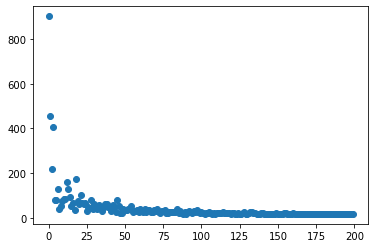

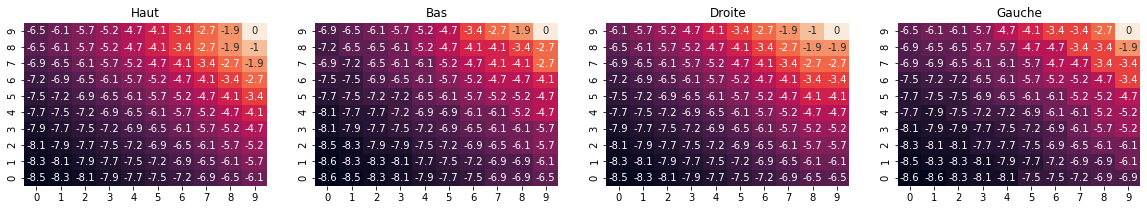

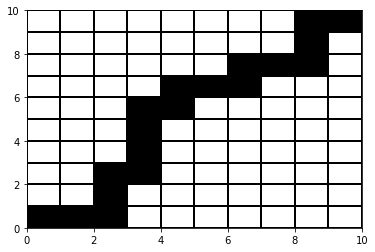

In [60]:
q = np.zeros([10,10,5])
q = Q_learning(q,steps = 200)
plot_q(q)
plot_greedy(q)

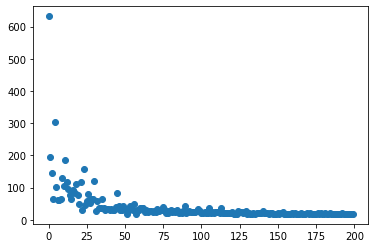

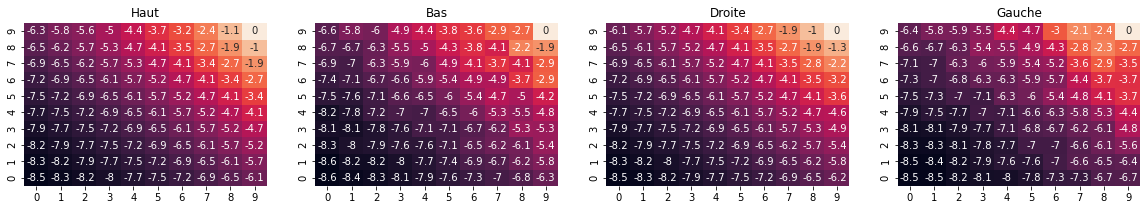

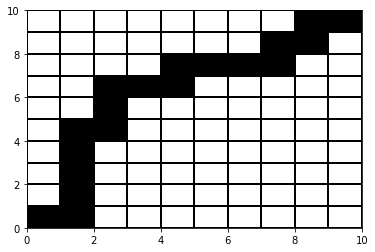

In [61]:
q = np.zeros([10,10,5])
q = expected_sarsa(q,steps= 200)
plot_q(q)
plot_greedy(q)

In [7]:
def traceQupdate(q,trace , s0, a0, q1):
    trace[s0[0],s0[1],a0] += 1
    q += trace*(0.9*q1-1-q[s0[0],s0[1],a0])
    trace *= 0.7
    return q, trace

def trace_sarsa(q,steps= 200):
    end = np.array([9,9])
    hist = []
    for step in range(1,steps+1):
        trace = np.zeros_like(q)
        s = np.array([0,0])
        e = 1/step
        i = 0
        while np.any(s != end):
            s2, a = max_action(q,s,e)
            expected = np.dot(q[s2[0],s2[1]],policy(q,s2,e))
            q, trace = traceQupdate(q,trace,s,a,expected)
            s = s2
            i += 1
        hist.append(i)
    plt.scatter(range(len(hist)),hist)
    plt.show()
    return q,trace

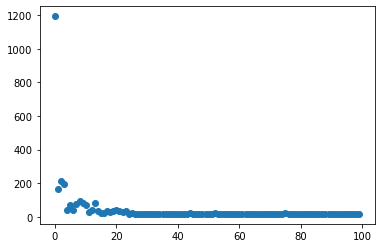

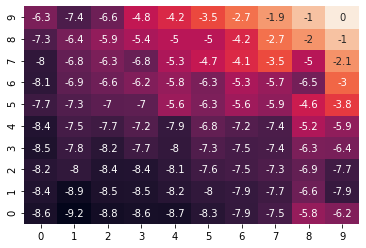

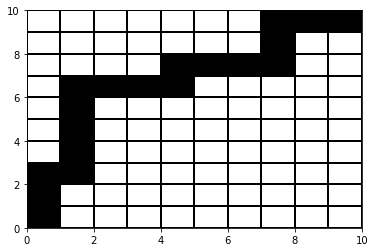

In [8]:
q = np.zeros([10,10,5])
q,trace = trace_sarsa(q,steps= 100)
plot_maxq(q)
plot_greedy(q)

In [3]:
def dtraceQupdate(q,trace , s0, a0, q1, qo, alpha, lambda_, gamma, end):
    trace *= lambda_*gamma
    trace[s0[0],s0[1],a0] = 1 - alpha*lambda_*gamma*trace[s0[0],s0[1],a0]
    r = 1.0 if end else -0.01
    q += alpha*trace*(gamma*q1 + r - qo)
    q[s0[0],s0[1],a0] -= alpha*(q[s0[0],s0[1],a0]-qo)
    return q, trace

def dtrace_sarsa(q,steps=200, alpha=1.0, lambda_=1.0, gamma=0.9):
    end = np.array([9,9])
    mean = 0
    for step in range(1,steps+1):
        trace = np.zeros_like(q)
        s = np.array([0,0])
        i = 0
        e = 1/step
        qo = 0
        while np.any(s != end):
            s2, a = max_action(q,s,e)
            expected = np.dot(q[s2[0],s2[1]],policy(q,s2,e))
            q, trace = dtraceQupdate(q,trace,s,a,expected,qo, alpha, lambda_, gamma, end=np.all(s2==end))
            s = s2
            qo = expected
            i += 1
        mean += i
    return q,trace, mean/steps

In [5]:
alpha = 0.4
lambda_ = 0.7
gamma = 0.9
steps = 50
mean = 0
n_runs = 100
for _ in tqdm(range(n_runs)):
    q = np.zeros([10,10,5])
    q, trace, m = dtrace_sarsa(q,steps, alpha, lambda_, gamma)
    mean += m
print(mean/n_runs)

100%|██████████| 100/100 [00:28<00:00,  3.46it/s]

54.683399999999985
